# Convolutional autoencoder

This notebook is an implementation of a simple autoencoder and classifier. For input I will consume a dataset of digits from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Multiple+Features). It comprises of 2000 handwritten digits (0 through 9). It offers different features, however I will only use the pixel features, since it is the most raw. Each pixel is an average of a $2 \times 3$ window over the original image as a grayscale value.

The task will be to create an autoencoder which will learn to very efficiently represent an image in a learned coding. In this case, an image which has 240 pixels (and thus 240 floats) will be compressed into only 2 floating point values (latent dimension), this is a 99.22% compression ratio. The autoencoder consists of 2 parts: an encoder and a decoder. Their task repectively is to encode an image into some efficient coding and to decode it back to the original image. To prevent the network from learning the identity function the network contains bottleneck layers which force it to learn some latent representation instead of copying the values over.

Next, as an added bonus a classifier will be trained to classify images just based off their coding.

## Prerequisites

This Jupyter notebook uses the Julia kernel (v1.7.1) and thus requires it. The dataset is included in the repository, so there is no need to download it.

## Architecture

The model consists of 3 components:

- An **encoder** whose job is to reduce the input space to a smaller representation. This will be a convolutional neural network, this will improve the quality of extracted features.
- A **decoder** receives the output of the encoder and tries to reconstruct the original input. This will be a transposed convolutional neural network.
- A **classifier** will take encoder's output and learn to classify it to appropriate classes. This will be a dense neural network.

![Architecture](assets/architecture.png)

## Installing dependencies

While I like implementing ML algorithms from scratch, this project does not introduce any new algorithms for me, it's just a compilation of topics which I have learned and implemented before. Thus I will use [FluxML](https://fluxml.ai), a simple Julia ML library which exposes some commonly used algorithms. Additionally some helper library will be used, for instances `Plots` for plotting.

In [1]:
import Pkg
# For ML primitives
Pkg.add("Flux")
# For ploting
Pkg.add("Plots")
# For decompressing Gzip files
Pkg.add("GZip")
# For displaying images
Pkg.add("Images")
# Utility for showing loop progress
Pkg.add("ProgressMeter")
# Binary serde: saves/loads models
Pkg.add("BSON")
# For notebook interactive components
# For it to work, install the `webio_jupyter_extension` extension: 
# `python3 -m pip install --upgrade webio_jupyter_extension`
Pkg.add("Interact")
Pkg.add("WebIO")

    Updating registry at `~/.julia/registries/General.toml`
┌ Warning: could not download https://pkg.julialang.org/registries
│   exception = Downloads.RequestError("https://pkg.julialang.org/registries", 6, "Could not resolve host: pkg.julialang.org", Downloads.Response(nothing, "https://pkg.julialang.org/registries", 0, "", Pair{String, String}[]))
└ @ Pkg.Registry /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.7/Pkg/src/Registry/Registry.jl:82
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/

## Reading data

The dataset follows a weird format (namely matches the regex `(  (0|1|2|3|4|5|6))+`) so it is cumbersome to parse. I will stick to `Float32` as the data type as it is faster than `Float64` and the extra precision of `Float64` offers no added value.

Images come in the $15 \times 16$ resolution which will be a problem for the CNN (or actually the transposed CNN which would then have to reconstruct an uneven resolution) so I will pad each picture with a row of black pixels. This should not affect the results in any meaningful manner. Data is immediatly normalized such that $p_{i,j} \in [0; 1]$ where $p_{i,j}$ is the $i,j$th-pixel.

In [2]:
using GZip

# dimensions of the image
const DIM = (16, 16)
# data size used
const DATA_TYPE = Float32
# amount of classes
const N_CLASSES = 10

dataset = GZip.open("assets/mfeat-pix.gz") do io
    data = readlines(io) .|> 
        # skip spaces in file
        x -> x[3:3:end] |>
        # get chars
        collect .|>
        # parse to integer
        x -> parse(Int, x)
    # transform to matrix
    data = permutedims(hcat(data...))
    # normalize and transform to column major
    DATA_TYPE.(data ./ maximum(data))' |>
        # pad pictures from the right to have 16x16
        x -> [reshape(x, 15, 16, 2000); repeat([0], 1, 16, 2000)]
end

16×16×2000 Array{Float32, 3}:
[:, :, 1] =
 0.0       0.166667  0.5       0.833333  1.0  …  0.833333  0.166667  0.0
 0.5       1.0       1.0       1.0       1.0     1.0       0.833333  0.0
 0.666667  1.0       1.0       1.0       1.0     1.0       1.0       0.5
 0.666667  1.0       1.0       1.0       1.0     1.0       1.0       0.666667
 1.0       1.0       0.5       0.0       0.0     0.5       1.0       0.666667
 1.0       0.833333  0.0       0.0       0.0  …  0.166667  1.0       0.666667
 1.0       0.333333  0.0       0.0       0.0     0.0       1.0       0.666667
 1.0       0.5       0.0       0.0       0.0     0.0       1.0       0.666667
 1.0       1.0       0.833333  0.0       0.0     0.5       1.0       0.666667
 0.833333  1.0       1.0       0.666667  0.5     1.0       1.0       0.666667
 0.5       1.0       1.0       1.0       1.0  …  1.0       1.0       0.5
 0.166667  1.0       1.0       1.0       1.0     1.0       0.833333  0.0
 0.0       0.333333  1.0       1.0       1.0   

## Visualizing data

Before starting training, I will examine the data to look for any particular problems.

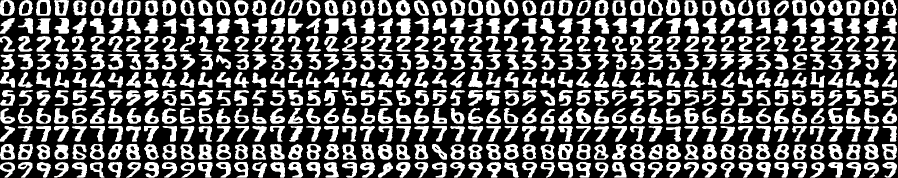

In [3]:
using Images

# returns an Images representation of an instance
img(d) = Gray.(d')

# retrieves instances of a dataset as a vector of views
instances(data) = @views [data[repeat([:], length(size(data))-1)..., i] for i in 1:size(data)[end]]

# visualize some instances
mosaicview(img.(instances(dataset)[1:4:end]), npad=2, nrow=N_CLASSES, rowmajor=true)

Immediatly I can see that the data looks ok and is distinguishable by human, however digit '1' looks very noisy. This shouldn't be a problem for the model, but it will then generate such '1's in result. I can also spot that there is a '3' that is upside down. I will leave it in, might be an interesting corner case.

Every class has exactly 200 instances, so the dataset is balanced and we can proceed.

## Preparing data

Flux's convolutional assumes a z-axis (for example RGB), but since our images are always in grayscale, this dimension will be always of size 1. Either way, the data has to be prepared in such a way that it does indeed have a z-axis. Additionally this layer assumes batches (training a CNN with online training would take forever), so actually the inputed data has to have 4 dimensions.

By the rule of thumb I will split the dataset in a 80/20 train/test split.

In [4]:
using Flux: onehotbatch, DataLoader

# reshapes the data to be inputable to the network (x, y, batch_size) -> (x, y, z, batch_size)
input(data) = reshape(data, DIM..., 1, :)
# reshapes the data to get output from the network (x, y, z, batch_size) -> (x, y, batch_size)
output(data) = @views data[:, :, 1, :]

# create labels
labels = [(i-1) ÷ 200 for i in 1:size(dataset, 3)]

# create a sparse matrix representing the classifier output vectors
ys = onehotbatch(labels, 0:N_CLASSES-1)

# split into train/test (80/20) set
const TRAIN_FRAC = 0.8

(c_train_x, c_train_y), (c_test_x, c_test_y) = DataLoader(
    (input(dataset), ys), batchsize=size(dataset)[end] * TRAIN_FRAC |> floor |> Int, shuffle=true)

(ae_train_x, ae_train_y), (ae_test_x, ae_test_y) = DataLoader(
    (input(dataset), input(dataset)), batchsize=size(dataset)[end] * TRAIN_FRAC |> floor |> Int, shuffle=true);

To be able to recover the model later on, I will save the parameters in a `.bson` file.

In [5]:
using BSON: @save, @load

const ENCODER_PATH = "assets/encoder.bson";
const DECODER_PATH = "assets/decoder.bson";
const CLASSIFIER_PATH = "assets/classifier.bson";

## Constructing the model

[FluxML](https://fluxml.ai/) will be used for ML primitives. It offers a compile time Automatic-Differentiation engine, [Zygote](https://github.com/FluxML/Zygote.jl). There is no handwritten gradient calculation code (neither by me nor by the library authors).

First I will have to create a custom Flux layer which will handle reshaping data.

In [6]:
using Flux

# custom Flux layer for reshaping data 
struct Reshape
    shape
end
(l::Reshape)(x) = reshape(x, l.shape)
Flux.@functor Reshape ()

### Hyperparameters

I do not have much experience with fine tuning hyperparameters so many of those are derived from online articles or by testing different configurations. The most important bits are:

- ADAM is the main optimizer
- Latent dimension of 2
- ReLU for most layers except for a sigmoid function for the decoder's last layer, and lack of any activation function for last layers of the encoder and the classifier
- Weights and biases initialized with Glorot uniform
- MSE loss function for the autoencoder and logistic cross-entropy loss functino for the classifier

There is an evident lack of regularization. This is mainly because I have failed choose a regularizer which would yield positive results.

From now on, every variable prefixed by `ae_` is related to the autoencoder, and every variable prefixed by `c_` is related to the classifier.

In [7]:
# learning rate
const α = 3e-4

const BATCH_SIZE = 32

# latent space dimension, ie the size of the encoding
const LATENT_DIM = 2
display("Images will be compressed by $((1 - LATENT_DIM / prod(DIM)) * 100)%")

const AE_EPOCHS = 500
const C_EPOCHS = 500

# gradient optimizer
ae_opt = ADAM(α)
c_opt = ADAM(α)

# models
encoder = Chain(
    Conv((5, 5), 1 => 32, relu, pad=SamePad()),
    MaxPool((2, 2)),
    Conv((5, 5), 32 => 32, relu, pad=SamePad()),
    MaxPool((2, 2)),
    Conv((3, 3), 32 => 32, relu, pad=SamePad()),
    MaxPool((2, 2)),
    flatten,
    Dense(128, LATENT_DIM)
)
decoder = Chain(
    Dense(LATENT_DIM, 128, relu),
    Reshape((2, 2, 32, :)),
    # stride=2 to "undo" max pooling
    ConvTranspose((3, 3), 32 => 32, relu, stride=2, pad=SamePad()),
    ConvTranspose((5, 5), 32 => 32, relu, stride=2, pad=SamePad()),
    ConvTranspose((5, 5), 32 => 1, σ, stride=2, pad=SamePad()),
)
classifier = Chain(Dense(LATENT_DIM, 32, relu), Dense(32, N_CLASSES))

# uncomment to load previously saved models
# @load ENCODER_PATH encoder
# @load DECODER_PATH decoder
# @load CLASSIFIER_PATH classifier

autoencoder = Chain(encoder, decoder)
full_classifier = Chain(encoder, classifier)

# model parameters, used by Zygote to extract gradients
ae_ps = Flux.params(autoencoder)
# for the classifier, we do not want to update the encoder weights
c_ps = Flux.params(classifier)

# loss functions that will be optimized
ae_loss(ŷ, y; kws...) = Flux.mse(ŷ, y; kws...)
c_loss(ŷ, y; kws...) = Flux.logitcrossentropy(ŷ, y; kws...);

"Images will be compressed by 99.21875%"

### Testing function

For testing, the loss and overall accuracy will be tracked.

In [8]:
using Flux: onecold

function c_accuracy_calc(data_loader, model)
    acc = 0
    num = 0
    for (x, y) in data_loader
        ŷ = model(x)
        # check how many correct predictions were made based on argmax of the output
        acc += sum(onecold(ŷ) .== onecold(y))
        num += size(x)[end]
    end
    return acc / num
end

function c_loss_calc(data_loader, model)
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        ŷ = model(x)
        ls += c_loss(ŷ, y, agg=sum)
        num +=  size(x)[end]
    end
    return ls / num
end

function ae_loss_calc(data_loader, model)
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        ŷ = model(x)
        ls += ae_loss(ŷ, y, agg=sum)
        num +=  size(x)[end]
    end
    return ls / num
end;

ae_loss_calc (generic function with 1 method)

## Training

### Autoencoder

Finally, we are ready to train the model. This step is straight forward:

1. Save initial loss for both train and test data
2. For every epoch:
    1. Get a batch
    2. Get the gradient from Zygote by computing the loss
    3. Update parameters based on the gradient and optimizer
    4. Repeat for all batches
    5. Check current loss
3. Save the model every now and then

In [9]:
using ProgressMeter

ae_train_loader = DataLoader((ae_train_x, ae_train_y), batchsize=BATCH_SIZE, shuffle=true)
ae_test_loader = DataLoader((ae_test_x, ae_test_y), batchsize=BATCH_SIZE)

ae_losses_train = [ae_loss_calc(ae_train_loader, autoencoder)]
ae_losses_test = [ae_loss_calc(ae_test_loader, autoencoder)]

@showprogress for epoch in 1:AE_EPOCHS
    for (x, y) in ae_train_loader
        ∇ = gradient(ae_ps) do 
            ae_loss(autoencoder(x), y)
        end
        Flux.Optimise.update!(ae_opt, ae_ps, ∇)
    end
    
    push!(ae_losses_train, ae_loss_calc(ae_train_loader, autoencoder))
    push!(ae_losses_test, ae_loss_calc(ae_test_loader, autoencoder))
    
    # save every 100 epochs
    if epoch % 100 == 0
        @save DECODER_PATH decoder
        @save ENCODER_PATH encoder
    end
end



Progress: 100%|█████████████████████████████████████████| Time: 0:31:23


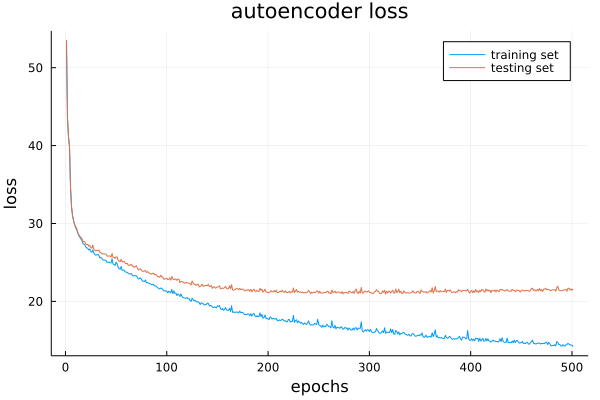

In [20]:
using Plots

plot(ae_losses_train, label="training set", title="autoencoder loss", xlabel="epochs", ylabel="loss")
plot!(ae_losses_test, label="testing set")

The model is very clearly overfitting the data. At epoch ~150 the model is no longer learning but just remembering the individual dataset instances.

### Classifier

Training a classifier follows the same steps. One slight difference is that we also track the accuracy throughout the epochs. During this training encoder's parameters are **not** being updated.

In [11]:
c_train_loader = DataLoader((c_train_x, c_train_y), batchsize=BATCH_SIZE, shuffle=true)
c_test_loader = DataLoader((c_test_x, c_test_y), batchsize=BATCH_SIZE)

c_losses_train = [c_loss_calc(c_train_loader, full_classifier)]
c_losses_test = [c_loss_calc(c_test_loader, full_classifier)]
c_acc_train = [c_accuracy_calc(c_train_loader, full_classifier)]
c_acc_test = [c_accuracy_calc(c_test_loader, full_classifier)]

@showprogress for epoch in 1:C_EPOCHS
    for (x, y) in c_train_loader
        ∇ = gradient(c_ps) do 
            c_loss(full_classifier(x), y)
        end
        Flux.Optimise.update!(c_opt, c_ps, ∇)
    end
    
    push!(c_losses_train, c_loss_calc(c_train_loader, full_classifier))
    push!(c_losses_test, c_loss_calc(c_test_loader, full_classifier))
    push!(c_acc_train, c_accuracy_calc(c_train_loader, full_classifier))
    push!(c_acc_test, c_accuracy_calc(c_test_loader, full_classifier))
    
    # save every 100 epochs
    if epoch % 100 == 0
        @save CLASSIFIER_PATH classifier
    end
end



Progress: 100%|█████████████████████████████████████████| Time: 0:28:35


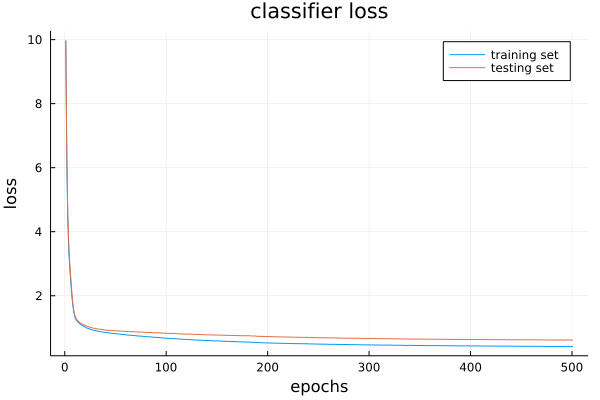

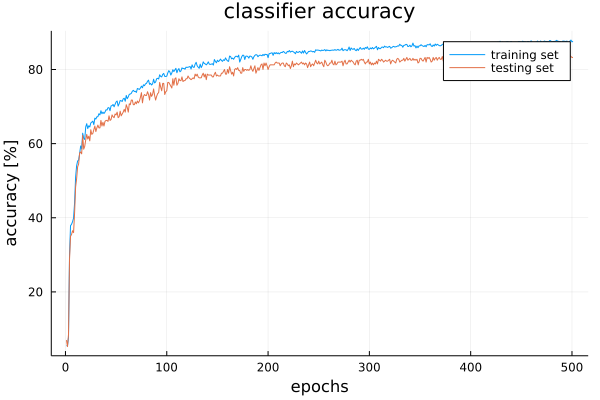

In [25]:
plot(c_losses_train, label="training set", title="classifier loss", xlabel="epochs", ylabel="loss")
display(plot!(c_losses_test, label="testing set"))

plot(c_acc_train .* 100, label="training set", title="classifier accuracy", xlabel="epochs", ylabel="accuracy [%]")
display(plot!(c_acc_test .* 100, label="testing set"))

The classifier learns the distribution very quickly, this can be attributed to the pre-trained encoder which returns meaningful data. The model does not seem to overfit. It is important to note however that a model trained specifically for classification will perform much better; I have done exactly that, deploying a simple dense NN yields results as high as 98% accuracy compared to measly 83% by this encoder-classifier model.

## Results

Let's start by visualizing the recontructed images

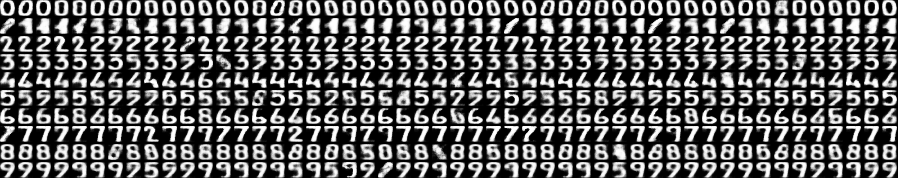

In [27]:
# render generated images from input for some instances
mosaicview(
    img.(dataset[:, :, 1:4:end] |> input |> autoencoder |> output |> instances),
    npad=2, nrow=N_CLASSES, rowmajor=true)

Some resulting images are very sharp, others are a completely wrong digit. What is worse, the wrong digits are sharp too, showing that the model is quite sure about this result. This, again, is due to the complete overfit of the model. A solution would be to stop the training at the previously mentioned 150 epochs. This would at least produce less arrogant results! ;)

In [14]:
using Interact

@manipulate for l1=-100:100, l2=-100:100
    l1, l2 = DATA_TYPE(l1), DATA_TYPE(l2)
    img(decoder([l1; l2]) |> output |> instances |> first)
end

WebIO._IJuliaInit()

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["l1"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => -100, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
0, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/shilangyu/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/shilangyu/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/shilangyu/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/home/shilangyu/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/home/shilangyu/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f68d5eea120, Task (runnable) @0x00007f68d5eea120), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-100\",\"-99\",\"-98\",\"-97\",\"-96\",\"-95\",\"-94\",\"-93\",\"-92\",\"-91\",\"-90\",\"-89\",\"-88\",\"-87\",\"-86\",\"-85\",\"-84\",\"-83\",\"-82\",\"-81\",\"-80\",\"-79\",\"-78\",\"-77\",\"-76\",\"-75\",\"-74\",\"-73\",\"-72\",\"-71\",\"-70\",\"-69\"

Above a small interactive example is shown, one can move the sliders to modify the latent space and see the effects it has on the output image.

## 2D manifold

Since the latent dimension is 2, it can also be easily visualized to show the transition states between the domain of the latent space (here assumed to be in some range inferred from the dataset)

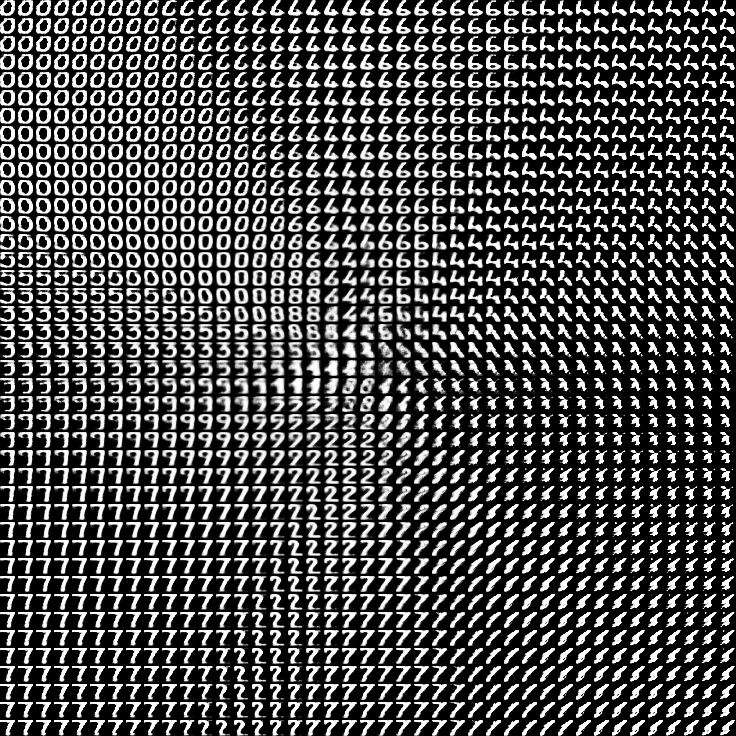

In [15]:
mosaicview(
    img.(decoder(hcat([[x; y] for x in -100:5:100, y in -100:5:100]...)) |> output |> instances),
    npad=2, nrow=41, rowmajor=true)

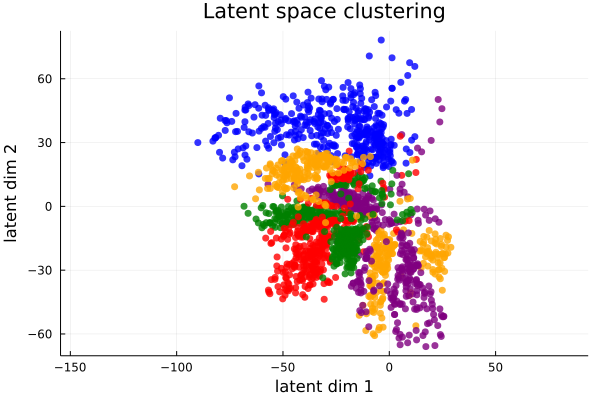

In [29]:
plt = scatter(palette=:rainbow, title="Latent space clustering", xlabel="latent dim 1", ylabel="latent dim 2")
for (x, y) in zip(instances(dataset), labels)
    l1, l2 = encoder(input(x))[:, :, 1]
    scatter!([l1], [l2],
        markerstrokewidth=0, markeralpha=0.8,
        aspect_ratio=1,
        markercolor=y, label="")
end
plt

This is my favorite graph: it shows that the autoencoder managed to successfully cluster the images to their respective classes. Each color represents a class (ie. digit), and we can see that the same class is close to each other.

This also means a clustering algorithm could be quite efficient at classification once the autoencoder is trained.

## References

1. Latent space explanation - https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d
2. Dataset - https://archive.ics.uci.edu/ml/datasets/Multiple+Features
3. Zygote AD - https://arxiv.org/abs/1810.07951